In [1]:
import cv2
import numpy as np
import pkg_resources
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
import os

FACES_PATH = '../data/face_detection/faces/'


In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
class PNet(tf.keras.Model):
    def __init__(self):
        super(PNet, self).__init__(name="PNet")
        # Define layers here.
        self.conv1 = tf.keras.layers.Conv2D(10, (3, 3), name="conv1")
        self.prelu1 = tf.keras.layers.PReLU(tf.constant_initializer(0.25), shared_axes=[1, 2], name="prelu1")
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")
        self.conv2 = tf.keras.layers.Conv2D(16, (3, 3), name="conv2")
        self.prelu2 = tf.keras.layers.PReLU(tf.constant_initializer(0.25), shared_axes=[1, 2], name="prelu2")
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), name="conv3")
        self.prelu3 = tf.keras.layers.PReLU(tf.constant_initializer(0.25), shared_axes=[1, 2], name="prelu3")
        self.cls_output = tf.keras.layers.Conv2D(2, (1, 1), activation="softmax", name="conv4-1")
        self.bbox_pred = tf.keras.layers.Conv2D(4, (1, 1), name="conv4-2")
        #self.landmark_pred = keras.layers.Conv2D(10, (1, 1), name="conv4_3")

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        scores = None

        x = self.conv1(inputs)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        scores = [self.cls_output(x), self.bbox_pred(x)]#, self.landmark_pred(x)]
        
        return scores


## Dataset iterable engine

In [5]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


In [6]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

print('Using device: ', device)

Using device:  /cpu:0


Test the PNet  to ensure that the implementation does not crash and produces outputs of the expected shape.
Pnet will output are:
1. Face classification,  size (batch,1,1,2) for 2 calss classification, "Face", and "Not face"
2. Bounding box  (batch,1,1,4) for 4 boundind box corrdinates (x,y,w,h)

In [6]:
def test_PNet(batch=64):    
    model = PNet()
    with tf.device(device):
        x = tf.zeros((batch, 12, 12, 3))
        classification_scores, bbox_score = model(x)
        print(model.summary())
        print('\nP-Net output size testing: \nclassificatin score output', classification_scores.shape,
              '\nbounsing box score output', bbox_score.shape)

batch_test = 32
test_PNet(batch_test)

Model: "PNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               multiple                  280       
_________________________________________________________________
prelu1 (PReLU)               multiple                  10        
_________________________________________________________________
pool1 (MaxPooling2D)         multiple                  0         
_________________________________________________________________
conv2 (Conv2D)               multiple                  1456      
_________________________________________________________________
prelu2 (PReLU)               multiple                  16        
_________________________________________________________________
conv3 (Conv2D)               multiple                  4640      
_________________________________________________________________
prelu3 (PReLU)               multiple                  32     

In [8]:
training_size = 6000

def read_pos_images():
    #Read positive images:
    path, __, filenames = next(os.walk(FACES_PATH+'pos_train/'))
    file_count = training_size #len(filenames)
    images = np.empty([0,12,3])
    for i in range(file_count):
        j=i+1
        img=cv2.imread(f"{path}{j}.bmp")
        images=np.append(images,img,axis=0)
    #Create list of probabilities:
    prob=[]
    for i in range(file_count):
        prob.append([[[0.0,1.0]]])
    #Create list of coordinates:
    coordinates=[]
    file = open(FACES_PATH+'coordinates.txt','r')
    lines = file.readlines()
    lines = [line[:-1] for line in lines]
    #idx=[1,0,3,2]
    idx=[0,1,2,3]
    f_count = 0
    for line in lines:
        line = line.split(" ")
        line = line[1]
        line=line[1:-1]
        line = line.split(",")
        #Transpose coordinates
        x=0
        nline=[]
        for i in idx:
            nline.append(line[i])
            x=x+1
        line=[[[float(c) for c in nline]]]
        coordinates.append(line)
        f_count = f_count+1
        if f_count == file_count:
            break
    #Return images, probs, and coordinates
    return images, prob, coordinates

def read_neg_images():
    #Read negative images:
    path, __, filenames = next(os.walk(FACES_PATH+'neg_train/'))
    file_count = training_size #len(filenames)
    images = np.empty([0,12,3])
    for i in range(file_count):
        j=i+1
        img=cv2.imread(f"{path}{j}.bmp")
        images=np.append(images,img,axis=0)
    #Create list of probabilities:
    prob=[]
    for i in range(file_count):
        prob.append([[[1.0,0.0]]])
    #Create list of coordinates:
    coordinates=[]
    for i in range(file_count):
        coordinates.append([[[0.0,0.0,0.0,0.0]]])
    #Return images, prob, coordinates
    return images, prob, coordinates

#Read in all images, probabilities, and coordinates
pimages, pprob, pcoordinates = read_pos_images()
nimages, nprob, ncoordinates = read_neg_images()
o_images=np.append(pimages,nimages,axis=0)
o_images=np.reshape(o_images,(-1,12,12,3))
o_prob=pprob+nprob
o_coordinates=pcoordinates+ncoordinates

#Shuffle them up using an index
idx=np.arange(len(o_prob))
np.random.shuffle(idx)
images=np.empty_like(o_images)
c=0
for i in idx:
    images[c]=o_images[i]
    c=c+1
#images=(np.float32)(images-127.5)/128.0
images=(np.float32)(images)/255

#images = np.transpose(images, (0, 2, 1, 3)) #Transpose images
prob=[]
for i in idx:
    prob.append(o_prob[i])
coordinates=[]
for i in idx:
    coordinates.append(o_coordinates[i])

In [9]:
print('X_data , Image data shape ', images.shape)
print('y_classification_data , Classification ground true data shape ' ,np.array(prob).shape)
print('y_bbox_data , Coordinates ground true data shape ', np.array(coordinates).shape)

X_data , Image data shape  (12000, 12, 12, 3)
y_classification_data , Classification ground true data shape  (12000, 1, 1, 2)
y_bbox_data , Coordinates ground true data shape  (12000, 1, 1, 4)


## Create X_data for train and validation

In [10]:
len(pcoordinates)

6000

In [11]:
X_data = images

In [12]:
print('X_data shape',X_data.shape)

X_data shape (12000, 12, 12, 3)


In [16]:
del images

## Create "y_data" for train and validation

In [17]:
y_data = np.concatenate((np.array(prob), np.array(coordinates)), axis=3)

In [18]:
print('y_data shape',y_data.shape)

y_data shape (12000, 1, 1, 6)


In [19]:
print('y_data Classification shape', y_data[:,:,:,:2].shape)
print('y_data Coordinate shape',y_data[:,:,:,2:].shape)

y_data Classification shape (12000, 1, 1, 2)
y_data Coordinate shape (12000, 1, 1, 4)


## Divide dataset to "train', "val" and "test"

In [20]:
def load_data(X, y, training_prec = 0.7, val_prec = 0.1, test_prec = 0.2):
        data_length = len(X)
        num_training = np.int(data_length * training_prec)
        num_validation = np.int(data_length * val_prec)
        
        mask = range(num_training)
        X_train = X[mask]
        y_train = y[mask]
        mask = range(num_training, num_training + num_validation)
        X_val = X[mask]
        y_val = y[mask]
        mask = range(num_training + num_validation, data_length)
        X_test = X[mask]
        y_test = y[mask]
        
        return X_train, y_train, X_val, y_val, X_test, y_test


In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data(X_data, y_data)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (8400, 12, 12, 3)
Train labels shape:  (8400, 1, 1, 6) float64
Validation data shape:  (1200, 12, 12, 3)
Validation labels shape:  (1200, 1, 1, 6)
Test data shape:  (2400, 12, 12, 3)
Test labels shape:  (2400, 1, 1, 6)


In [22]:
train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

## Lets test a single batch 

In [22]:
def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate) 
    #return tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)

In [23]:
model = PNet()
optimizer = optimizer_init_fn()

In [24]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
bbox_loss = tf.keras.losses.MeanSquaredError()

In [25]:
train_loss = tf.keras.metrics.BinaryCrossentropy(name='train_classification_loss')
train_bbox_loss = tf.keras.metrics.MeanSquaredError(name='train_bbox_loss')


In [26]:
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

### Forward pass loss

In [27]:
X_train_batch = X_train[:32,:,:,:]
y_train_batch = y_train[:32,:,:,:]

# Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
train_loss.reset_states()
train_accuracy.reset_states()


with tf.GradientTape() as tape:
    classification_scores, bbox_scores = model(X_train_batch , training=True)
    prediction_loss = classification_loss(y_train_batch[:,:,:,:2], classification_scores)
    coordinate_loss = bbox_loss(y_train_batch[:,:,:,2:], bbox_scores)
    loss = prediction_loss + 0.5 * coordinate_loss
    # Print loss 
    print('Classification loss',prediction_loss)
    print(coordinate_loss)
    print(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update the metrics
    train_loss.update_state(y_train_batch[:,:,:,:2], classification_scores)
    train_bbox_loss.update_state(y_train_batch[:,:,:,2:], bbox_scores)
    train_accuracy.update_state(y_train_batch[:,:,:,:2], classification_scores)

Classification loss tf.Tensor(0.6877527, shape=(), dtype=float32)
tf.Tensor(0.23161797, shape=(), dtype=float32)
tf.Tensor(0.8035617, shape=(), dtype=float32)


In [29]:
template = 'Loss: {}, Accuracy: {}'
print (template.format(train_loss.result(),
                       train_accuracy.result()*100))

Loss: 0.6877527236938477, Accuracy: 59.375


In [23]:
def train(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on  training set and periodically checks
    accuracy on the validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """    
    with tf.device(device):
        
        #Set up summary writers to write the summaries to disk in a different logs directory:
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
        test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        test_summary_writer = tf.summary.create_file_writer(test_log_dir)
        
        #compute the loss function over the classification and ovr bounding box 
        classification_loss = tf.keras.losses.BinaryCrossentropy()
        bbox_loss = tf.keras.losses.MeanSquaredError()        
        
        model = model_init_fn()
        optimizer = optimizer_init_fn()
        
        train_loss = tf.keras.metrics.BinaryCrossentropy(name='train_classification_loss')
        train_bbox_loss = tf.keras.metrics.MeanSquaredError(name='train_bbox_loss')
        
        train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
            
        #val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_classification_loss')
        val_bbox_loss = tf.keras.metrics.MeanSquaredError(name='val_bbox_loss')

        val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')
        
        t = 0
        for epoch in range(num_epochs):
            
            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_bbox_loss.reset_states()
            
            train_accuracy.reset_states()
            
            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:
                    
                    # Use the model function to build the forward pass.
                    classification_scores, bbox_scores = model(x_np, training=True)
                    prediction_loss = classification_loss(y_np[:,:,:,:2], classification_scores)
                    coordinate_loss = bbox_loss(y_np[:,:,:,2:], bbox_scores)
                    loss = prediction_loss + 0.5 * coordinate_loss * y_np[:,:,:,1]
                    # Print loss 
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
                    # Update the metrics
                    train_loss.update_state(y_np[:,:,:,:2], classification_scores)
                    train_bbox_loss.update_state(y_np[:,:,:,2:], bbox_scores*y_np[:,:,:,1] )
                    train_accuracy.update_state(y_np[:,:,:,:2], classification_scores)
                    
                    with train_summary_writer.as_default():
                        tf.summary.scalar('loss', train_loss.result(), step=epoch)
                        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)


                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_bbox_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            classification_scores, bbox_scores = model(test_x, training=False)
                            t_prediction_loss = classification_loss(test_y[:,:,:,:2], classification_scores)
                            t_coordinate_loss = bbox_loss(test_y[:,:,:,2:], bbox_scores)
                            t_loss = t_prediction_loss + 0.5 * t_coordinate_loss * test_y[:,:,:,1]

                            val_loss.update_state(test_y[:,:,:,:2], classification_scores)
                            val_bbox_loss.update_state(test_y[:,:,:,2:], bbox_scores*test_y[:,:,:,1])
                            val_accuracy.update_state(test_y[:,:,:,:2], classification_scores)
                            
                            with test_summary_writer.as_default():
                                tf.summary.scalar('loss', val_loss.result(), step=epoch)
                                tf.summary.scalar('accuracy', val_accuracy.result(), step=epoch)

                        
                        template = 'Iteration {}, Epoch {}, \nLoss: {}, Bbox loss: {}, Accuracy: {},\nVal Loss: {}, Val Bbox Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_bbox_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_bbox_loss.result(),  
                                             val_accuracy.result()*100))
                    t += 1
    return model

In [24]:
#device = '/device:GPU:0'   # Change this to a CPU/GPU as you wish!
#device = '/cpu:0'        # Change this to a CPU/GPU as you wish!

# Constant to control how often we print when training models
print_every = 50
num_epochs = 50

#model = PNet()

def model_init_fn():
    return PNet()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate) 
    #return tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    

In [28]:
logs_base_dir = "./logs/gradient_tape"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 30180), started 0:01:07 ago. (Use '!kill 30180' to kill it.)

In [29]:
model = train(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, 
Loss: 0.6861038208007812, Bbox loss: 0.15497726202011108, Accuracy: 59.375,
Val Loss: 0.6925285458564758, Val Bbox Loss: 0.19234471023082733, Val Accuracy: 49.83333206176758
Iteration 50, Epoch 1, 
Loss: 0.6520605087280273, Bbox loss: 0.16084203124046326, Accuracy: 61.09068298339844,
Val Loss: 0.574312150478363, Val Bbox Loss: 0.15377368032932281, Val Accuracy: 69.75
Iteration 100, Epoch 1, 
Loss: 0.5884343385696411, Bbox loss: 0.1492147296667099, Accuracy: 67.82178497314453,
Val Loss: 0.4888328015804291, Val Bbox Loss: 0.13528156280517578, Val Accuracy: 78.58333587646484
Iteration 150, Epoch 2, 
Loss: 0.4377756714820862, Bbox loss: 0.12810289859771729, Accuracy: 80.75658416748047,
Val Loss: 0.42043137550354004, Val Bbox Loss: 0.12940195202827454, Val Accuracy: 82.83332824707031
Iteration 200, Epoch 2, 
Loss: 0.43884772062301636, Bbox loss: 0.12894324958324432, Accuracy: 81.06884002685547,
Val Loss: 0.42011669278144836, Val Bbox Loss: 0.12856724858283997, Val Acc

Iteration 2000, Epoch 16, 
Loss: 0.1506187617778778, Bbox loss: 0.11074385046958923, Accuracy: 94.19642639160156,
Val Loss: 0.1880979686975479, Val Bbox Loss: 0.1143994852900505, Val Accuracy: 92.5
Iteration 2050, Epoch 16, 
Loss: 0.1618334949016571, Bbox loss: 0.11153340339660645, Accuracy: 93.66197204589844,
Val Loss: 0.16445216536521912, Val Bbox Loss: 0.11354044079780579, Val Accuracy: 93.41666412353516
Iteration 2100, Epoch 16, 
Loss: 0.16520732641220093, Bbox loss: 0.11170683056116104, Accuracy: 93.42716979980469,
Val Loss: 0.1838395595550537, Val Bbox Loss: 0.11382992565631866, Val Accuracy: 92.75
Iteration 2150, Epoch 17, 
Loss: 0.1458612084388733, Bbox loss: 0.11098338663578033, Accuracy: 94.23077392578125,
Val Loss: 0.17033255100250244, Val Bbox Loss: 0.11413994431495667, Val Accuracy: 92.91666412353516
Iteration 2200, Epoch 17, 
Loss: 0.15340544283390045, Bbox loss: 0.11131443828344345, Accuracy: 93.9606704711914,
Val Loss: 0.16520348191261292, Val Bbox Loss: 0.1144676581025

Iteration 4000, Epoch 31, 
Loss: 0.08500190079212189, Bbox loss: 0.10671057552099228, Accuracy: 96.95122528076172,
Val Loss: 0.14238578081130981, Val Bbox Loss: 0.11067082732915878, Val Accuracy: 94.41666412353516
Iteration 4050, Epoch 31, 
Loss: 0.09261471033096313, Bbox loss: 0.10701925307512283, Accuracy: 96.61743927001953,
Val Loss: 0.13600298762321472, Val Bbox Loss: 0.1106797531247139, Val Accuracy: 94.0
Iteration 4100, Epoch 32, 
Loss: 0.0862443819642067, Bbox loss: 0.10373154282569885, Accuracy: 96.52777862548828,
Val Loss: 0.11833979189395905, Val Bbox Loss: 0.10936193913221359, Val Accuracy: 95.33332824707031
Iteration 4150, Epoch 32, 
Loss: 0.08948935568332672, Bbox loss: 0.10662893205881119, Accuracy: 96.84851837158203,
Val Loss: 0.14936251938343048, Val Bbox Loss: 0.11097956448793411, Val Accuracy: 94.0
Iteration 4200, Epoch 32, 
Loss: 0.09035372734069824, Bbox loss: 0.1065431460738182, Accuracy: 96.61697387695312,
Val Loss: 0.1265881508588791, Val Bbox Loss: 0.10970012098

Iteration 6000, Epoch 46, 
Loss: 0.055208347737789154, Bbox loss: 0.10522408783435822, Accuracy: 98.05327606201172,
Val Loss: 0.1297939419746399, Val Bbox Loss: 0.10984379798173904, Val Accuracy: 95.16666412353516
Iteration 6050, Epoch 46, 
Loss: 0.053453873842954636, Bbox loss: 0.10530669242143631, Accuracy: 98.28266143798828,
Val Loss: 0.09989511221647263, Val Bbox Loss: 0.10868560522794724, Val Accuracy: 96.66666412353516
Iteration 6100, Epoch 47, 
Loss: 0.04173148795962334, Bbox loss: 0.10407020896673203, Accuracy: 98.59913635253906,
Val Loss: 0.15562623739242554, Val Bbox Loss: 0.11157460510730743, Val Accuracy: 95.08332824707031
Iteration 6150, Epoch 47, 
Loss: 0.054010286927223206, Bbox loss: 0.10530155152082443, Accuracy: 98.33860778808594,
Val Loss: 0.12350188940763474, Val Bbox Loss: 0.10944396257400513, Val Accuracy: 95.91666412353516
Iteration 6200, Epoch 47, 
Loss: 0.051265548914670944, Bbox loss: 0.10545526444911957, Accuracy: 98.31637573242188,
Val Loss: 0.13017006218433

## Test results

In [105]:
predictions = model.predict(X_test)

In [106]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

In [107]:
score = predictions[0]

In [108]:
bbox = predictions[1]

In [109]:
score = np.squeeze(score)
bbox = np.squeeze(bbox)

In [110]:
y_test_score = np.squeeze(y_test[:,:,:,:2])
y_test_bbox = np.squeeze(y_test[:,:,:,2:])

In [111]:
from sklearn.metrics import confusion_matrix, classification_report

In [112]:
print(classification_report(y_test_score, np.round(score)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1181
           1       0.93      0.98      0.96      1219

   micro avg       0.95      0.95      0.95      2400
   macro avg       0.96      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400
 samples avg       0.95      0.95      0.95      2400



In [113]:
print(confusion_matrix(y_test_score[:,1:2], np.round(score[:,1:2])))

[[1094   87]
 [  24 1195]]


In [161]:
score[100:110,1:]

array([[1.5034582e-03],
       [9.9999881e-01],
       [9.9942529e-01],
       [6.9643342e-05],
       [9.9997509e-01],
       [5.9466606e-06],
       [9.9910057e-01],
       [9.9999404e-01],
       [4.3008304e-09],
       [9.4043756e-01]], dtype=float32)

In [162]:
y_test_score[100:110,1:]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]])

C:\Users\yaron\AppData\Local\Continuum\anaconda3\envs\TF_20_env\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[4.3008304e-09]')

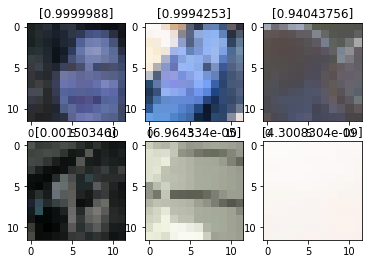

In [163]:
plt.subplots(2,3)
test_face = X_test[101]
plt.subplot(231)
plt.imshow(test_face)
plt.title(score[101,1:])
test_face = X_test[102]
plt.subplot(232)
plt.imshow(test_face)
plt.title(score[102,1:])
test_face = X_test[109]
plt.subplot(233)
plt.imshow(test_face)
plt.title(score[109,1:])

test_face = X_test[100]
plt.subplot(234)
plt.imshow(test_face)
plt.title(score[100,1:])
test_face = X_test[103]
plt.subplot(235)
plt.imshow(test_face)
plt.title(score[103,1:])
test_face = X_test[108]
plt.subplot(236)
plt.imshow(test_face)
plt.title(score[108,1:])

In [170]:
def plot_testset(index):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    ax.imshow(X_test[index])
    plt.title(score[index,1:])
    # Create a Rectangle patch
    x = round(12*bbox[index,0])
    y = round(12*bbox[index,1])
    w = round(12*bbox[index,2]) - x
    h = round(12*bbox[index,3]) - y
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    

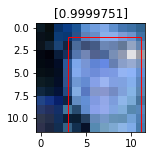

In [173]:
plot_testset(104)

In [168]:
bbox[101,:]

array([0.29608262, 0.02825493, 0.9423902 , 0.95727515], dtype=float32)

In [169]:
y_test_bbox[101,:]

array([0.25, 0.  , 1.  , 1.  ])

In [160]:
y_test_score[14,1]

0.0

In [ ]:
y_test_bbox[8,:]

In [ ]:
bbox[8,:]